In [125]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.colors 

In [33]:
data = pd.read_csv('data.csv')

data.set_index('shot_id', inplace=True)
data["action_type"] = data["action_type"].astype('object')
data["combined_shot_type"] = data["combined_shot_type"].astype('category')
data["game_event_id"] = data["game_event_id"].astype('category')
data["game_id"] = data["game_id"].astype('category')
data["period"] = data["period"].astype('object')
data["playoffs"] = data["playoffs"].astype('category')
data["season"] = data["season"].astype('category')
data["shot_made_flag"] = data["shot_made_flag"].astype('category')
data["shot_type"] = data["shot_type"].astype('category')
data["team_id"] = data["team_id"].astype('category')

In [65]:
data.head(10)


,action_type,combined_shot_type,game_event_id,game_id,lat,loc_x,loc_y,lon,minutes_remaining,period,...,shot_made_flag,shot_type,shot_zone_area,shot_zone_basic,shot_zone_range,team_id,team_name,game_date,matchup,opponent
shot_id,,,,,,,,,,,,,,,,,,,,,
1,Jump Shot,Jump Shot,10,20000012,33.9723,167,72,-118.1028,10,1,...,NaN,2PT Field Goal,Right Side(R),Mid-Range,16-24 ft.,1610612747,Los Angeles Lakers,2000-10-31,LAL @ POR,POR
2,Jump Shot,Jump Shot,12,20000012,34.0443,-157,0,-118.4268,10,1,...,0.0,2PT Field Goal,Left Side(L),Mid-Range,8-16 ft.,1610612747,Los Angeles Lakers,2000-10-31,LAL @ POR,POR
3,Jump Shot,Jump Shot,35,20000012,33.9093,-101,135,-118.3708,7,1,...,1.0,2PT Field Goal,Left Side Center(LC),Mid-Range,16-24 ft.,1610612747,Los Angeles Lakers,2000-10-31,LAL @ POR,POR
4,Jump Shot,Jump Shot,43,20000012,33.8693,138,175,-118.1318,6,1,...,0.0,2PT Field Goal,Right Side Center(RC),Mid-Range,16-24 ft.,1610612747,Los Angeles Lakers,2000-10-31,LAL @ POR,POR
5,Driving Dunk Shot,Dunk,155,20000012,34.0443,0,0,-118.2698,6,2,...,1.0,2PT Field Goal,Center(C),Restricted Area,Less Than 8 ft.,1610612747,Los Angeles Lakers,2000-10-31,LAL @ POR,POR
6,Jump Shot,Jump Shot,244,20000012,34.0553,-145,-11,-118.4148,9,3,...,0.0,2PT Field Goal,Left Side(L),Mid-Range,8-16 ft.,1610612747,Los Angeles Lakers,2000-10-31,LAL @ POR,POR
7,Layup Shot,Layup,251,20000012,34.0443,0,0,-118.2698,8,3,...,1.0,2PT Field Goal,Center(C),Restricted Area,Less Than 8 ft.,1610612747,Los Angeles Lakers,2000-10-31,LAL @ POR,POR
8,Jump Shot,Jump Shot,254,20000012,34.0163,1,28,-118.2688,8,3,...,NaN,2PT Field Goal,Center(C),Restricted Area,Less Than 8 ft.,1610612747,Los Angeles Lakers,2000-10-31,LAL @ POR,POR
9,Jump Shot,Jump Shot,265,20000012,33.9363,-65,108,-118.3348,6,3,...,1.0,2PT Field Goal,Left Side(L),In The Paint (Non-RA),8-16 ft.,1610612747,Los Angeles Lakers,2000-10-31,LAL @ POR,POR


In [35]:
print data.shape
unknown_mask = data['shot_made_flag'].isnull()

(30697, 24)


# Data Cleaning


In [36]:
data_cl = data.copy() # create a copy of data frame
target = data_cl['shot_made_flag'].copy()

# Remove some columns
data_cl.drop('team_id', axis=1, inplace=True) # Always one number
data_cl.drop('lat', axis=1, inplace=True) # Correlated with loc_x
data_cl.drop('lon', axis=1, inplace=True) # Correlated with loc_y
data_cl.drop('game_id', axis=1, inplace=True) # Independent
data_cl.drop('game_event_id', axis=1, inplace=True) # Independent
data_cl.drop('team_name', axis=1, inplace=True) # Always LA Lakers
data_cl.drop('shot_made_flag', axis=1, inplace=True)

# Remaining time
data_cl['seconds_from_period_end'] = 60 * data_cl['minutes_remaining'] + data_cl['seconds_remaining']
data_cl['last_5_sec_in_period'] = data_cl['seconds_from_period_end'] < 5

data_cl.drop('minutes_remaining', axis=1, inplace=True)
data_cl.drop('seconds_remaining', axis=1, inplace=True)
data_cl.drop('seconds_from_period_end', axis=1, inplace=True)

## Matchup - (away/home)
data_cl['home_play'] = data_cl['matchup'].str.contains('vs').astype('int')
data_cl.drop('matchup', axis=1, inplace=True)

# Game date
data_cl['game_date'] = pd.to_datetime(data_cl['game_date'])
data_cl['game_year'] = data_cl['game_date'].dt.year
data_cl['game_month'] = data_cl['game_date'].dt.month
data_cl.drop('game_date', axis=1, inplace=True)

#data_cl['loc_x'] = pd.cut(data_cl['loc_x'], 25)
#data_cl['loc_y'] = pd.cut(data_cl['loc_y'], 25)

# Replace 20 least common action types with value 'Other'
rare_action_types = data_cl['action_type'].value_counts().sort_values().index.values[:20]
data_cl.loc[data_cl['action_type'].isin(rare_action_types), 'action_type'] = 'Other'


In [37]:
categorial_cols = [
    'action_type', 'combined_shot_type', 'period', 'season', 'shot_type',
    'shot_zone_area', 'shot_zone_basic', 'shot_zone_range', 'game_year',
    'game_month', 'opponent']

for cc in categorial_cols:
    dummies = pd.get_dummies(data_cl[cc])
    dummies = dummies.add_prefix("{}#".format(cc))
    data_cl.drop(cc, axis=1, inplace=True)
    data_cl = data_cl.join(dummies)

In [38]:
data_cl.head(10)

,loc_x,loc_y,playoffs,shot_distance,last_5_sec_in_period,home_play,action_type#Alley Oop Dunk Shot,action_type#Alley Oop Layup shot,action_type#Driving Dunk Shot,action_type#Driving Finger Roll Layup Shot,...,opponent#PHI,opponent#PHX,opponent#POR,opponent#SAC,opponent#SAS,opponent#SEA,opponent#TOR,opponent#UTA,opponent#VAN,opponent#WAS
shot_id,,,,,,,,,,,,,,,,,,,,,
1,167,72,0,18,False,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
2,-157,0,0,15,False,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
3,-101,135,0,16,False,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
4,138,175,0,22,False,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
5,0,0,0,0,False,0,0,0,1,0,...,0,0,1,0,0,0,0,0,0,0
6,-145,-11,0,14,False,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
7,0,0,0,0,False,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
8,1,28,0,2,False,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
9,-65,108,0,12,False,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0


In [68]:

# Separate dataset for validation# Separa 
data_submit = data_cl[unknown_mask]

# Separate dataset for training
X = data_cl[~unknown_mask]
Y = target[~unknown_mask]

Xtrain = X.head(20000)
Ytrain = Y.head(20000)
Xtest = X.tail(5697)
Ytest = Y.tail(5697)


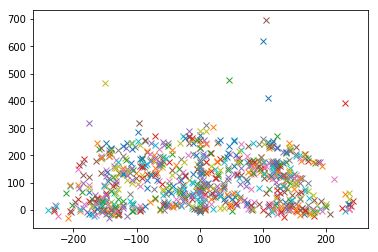

In [69]:
plt.figure(0)
for index, row in X.head(1000).iterrows():
    plt.plot(X.get_value(index, 'loc_x'), X.get_value(index, 'loc_y'), 'x')
plt.show()


# Models

In [99]:
from sklearn.decomposition import PCA, KernelPCA
from sklearn.cross_validation import KFold, cross_val_score
from sklearn.metrics import make_scorer, accuracy_score
from sklearn.feature_selection import VarianceThreshold, RFE, SelectKBest, chi2
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import BaggingClassifier, ExtraTreesClassifier, GradientBoostingClassifier, VotingClassifier, RandomForestClassifier, AdaBoostClassifier


In [77]:
model = RandomForestClassifier()
model.fit(Xtrain, Ytrain)
feature_imp = pd.DataFrame(model.feature_importances_, index=X.columns, columns=["importance"])
feat_imp_20 = feature_imp.sort_values("importance", ascending=False).head(20).index
feat_imp_20

shot_id
2        0.0
3        1.0
4        0.0
5        1.0
6        0.0
7        1.0
9        1.0
10       0.0
11       0.0
12       1.0
13       1.0
14       0.0
15       0.0
16       0.0
18       1.0
19       0.0
21       0.0
22       0.0
23       1.0
24       1.0
25       1.0
26       0.0
27       0.0
28       0.0
29       0.0
30       0.0
31       1.0
32       0.0
39       1.0
40       1.0
        ... 
23821    0.0
23822    1.0
23823    1.0
23824    0.0
23825    0.0
23826    0.0
23827    0.0
23829    1.0
23830    0.0
23831    0.0
23832    1.0
23835    0.0
23836    1.0
23837    0.0
23838    0.0
23839    1.0
23840    0.0
23841    1.0
23842    0.0
23843    1.0
23846    0.0
23847    0.0
23848    1.0
23849    1.0
23850    1.0
23851    0.0
23853    0.0
23854    0.0
23856    1.0
23857    1.0
Name: shot_made_flag, Length: 20000, dtype: category
Categories (2, float64): [0.0, 1.0]


Index([u'loc_x', u'loc_y', u'shot_distance', u'action_type#Jump Shot',
       u'home_play', u'period#1', u'period#3', u'period#4', u'period#2',
       u'action_type#Layup Shot', u'game_month#1', u'combined_shot_type#Dunk',
       u'shot_zone_basic#Restricted Area', u'game_month#12', u'game_month#11',
       u'game_month#3', u'game_month#2', u'action_type#Driving Layup Shot',
       u'game_month#4', u'opponent#HOU'],
      dtype='object')

In [105]:
y_pred = [int(x) for x in model.predict(Xtest)]
y_test = [int(Ytest.get_value(i)) for i in Ytest.keys()]
y_rand = []
for i in range(len(y_pred)):
    ran = np.random.rand()
    if ran <= .452:
        y_rand.append(1)
    else:
        y_rand.append(0)
        
print(accuracy_score(y_pred, Ytest))
print(accuracy_score(y_rand, Ytest))

0.653501843075
0.504124978059


In [ ]:
yprob = model.predict_proba(Xtest)
cmap = plt.cm.rainbow
norm = matplotlib.colors.Normalize(vmin=1.5, vmax=4.5)
plt.figure(1)
idx = 0
for index, row in Xtest.head(4000).iterrows():
    plt.plot(Xtest.get_value(index, 'loc_x'), Xtest.get_value(index, 'loc_y'), color=cmap(yprob[idx][1] * .3 + .7), marker = ',')
    idx+=1
# print(cmap(norm(yprob[0][0])))
print(cmap(.4))
# plt.plot(200, 200, color=(255, 255, 0, 0))
plt.show()



